In [40]:
from PIL import Image
import pytesseract
import numpy as np

## Sample Inferences of Pytesseract over Whole images

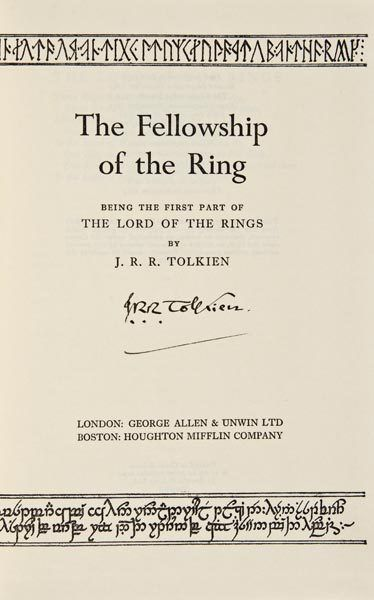

Text image:

BEATRASAINIXG PMNYCENDEYNA BABSNBRANE:

The Fellowship
of the Ring

FING THE PIRST PART OF
‘THE LORD OF THE RINGS

J. RR. TOLKIEN

ee

LONDON: GEORGE ALLEN & UNWIN LD
OSTON; HOUGHTON MIFFLIN COMPANY

aE hah Se eo




In [58]:
image_path = "samples/lotr_cover.jpg"
image = Image.open(image_path)
display(image)
text = pytesseract.image_to_string(image,lang="eng")
print(f"Text image:\n\n{text}")

In [59]:
print(f"Supported languages: {pytesseract.get_languages(config='')}")

Supported languages: ['eng', 'osd', 'spa']


### OCR Latency

Time execution of ocr over original image

In [60]:
print(f"Image shape is: {image.size}")

Image shape is: (374, 600)


In [61]:
%%timeit -r 4 -n 10
pytesseract.image_to_data(image)

241 ms ± 2.58 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)


Time execution over image half its original size

New image shape: (187, 300)



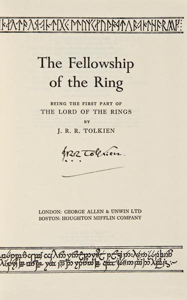

Text from downsized image:

PRASAMANC PYRE

The Fellowship
of the Ring




In [62]:
img_shape = image.size
new_size = int(img_shape[0]*0.5), int(img_shape[1]*0.5)
print(f"New image shape: {new_size}\n")
downsized_image = image.resize(new_size)
display(downsized_image)
text = pytesseract.image_to_string(downsized_image)
print(f"Text from downsized image:\n\n{text}")

Time execution over image a quarter its original size

In [ ]:
img_shape = image.size
new_size = int(img_shape[0]*0.25), int(img_shape[1]*0.25)
print(f"New image shape: {new_size}\n")
downsized_image = image.resize(new_size)
display(downsized_image)
text = pytesseract.image_to_string(downsized_image)
print(f"Text from downsized image:\n\n{text}")

In [64]:
%%timeit -r 4 -n 10
pytesseract.image_to_data(downsized_image)

103 ms ± 756 µs per loop (mean ± std. dev. of 4 runs, 10 loops each)


If comparing results ...

| Extracted Text                                                                                                                                                                                                       | Width | Height | FPS  |
|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|--------|------|
| BEATRASAINIXG PMNYCENDEYNA BABSNBRANE:  The Fellowship of the Ring  FING THE PIRST PART OF ‘THE LORD OF THE RINGS  J. RR. TOLKIEN  ee  LONDON: GEORGE ALLEN & UNWIN LD OSTON; HOUGHTON MIFFLIN COMPANY  aE hah Se eo | 374   | 600    | 4,06 |
| PRASAMANC PYRE  The Fellowship of the Ring                                                                                                                                                                           | 187   | 300    | 6,80 |
|                                                                                                                                                                                                                      | 93    | 150    | 9,80 |

Overall, it seems clear that pytesseract can't perform well when providing text that is surrounded heavily by background. Text detection and further recognition is reportedly the solution

## Including Text Detection with EAST before recognition

In [2]:
import cv2
import matplotlib.pyplot as plt

EAST_MODEL_PATH = ""
MIN_CONFIDENCE = 0.5
WIDTH = 320 # Must be multiple of 32
HEIGHT = 320 # Must be multiple of 32
MODEL_PATH = "models/frozen_east_text_detection.pb"

image_path = "samples/lotr_cover.jpg"
img = cv2.imread(image_path)
h, w = img.shape[:2]
print(f"Original image size: {(h,w)}")

Original image size: (600, 374)


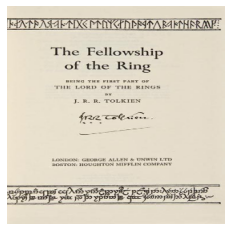

In [3]:
r_w = w / WIDTH
r_h = h / HEIGHT

resized_img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [4]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(MODEL_PATH)

[INFO] loading EAST text detector...


In [5]:
%%time
# construct a blob (preprocessed image) from the original 
# image and then perform a forward pass of the model to 
# obtain the two output layer sets
blob = cv2.dnn.blobFromImage(
    image = resized_img,
    scalefactor = 1.0,
    size = (WIDTH, HEIGHT),
	mean = (123.68, 116.78, 103.94),
    swapRB=True,
    crop=False
)
# Detect text over
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

CPU times: user 917 ms, sys: 169 ms, total: 1.09 s
Wall time: 194 ms


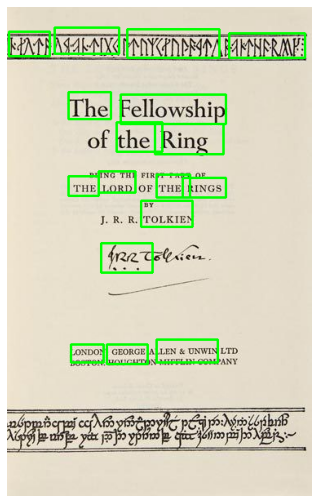

In [8]:
import numpy as np
from imutils.object_detection import non_max_suppression

drawn_img = img.copy()
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
    
    	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < MIN_CONFIDENCE:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		x2 = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		y2 = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		x1 = int(x2- w)
		y1 = int(y2 - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((x1, y1, x2, y2))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (x1, y1, x2, y2) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	x1 = int(x1 * r_w)
	y1 = int(y1 * r_h)
	x2 = int(x2 * r_w)
	y2 = int(y2 * r_h)
	# draw the bounding box on the image
	cv2.rectangle(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
# show the output image
plt.figure(figsize=(12,9))
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()